# HW 4 - Applied Machine Learning
# Clustering


> __TASK 2__ Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

## Import data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import operator

#from sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import *
from sklearn import metrics
from sklearn.decomposition import PCA as RandomizedPCA

#from helpers.py
from helpers import *

In [2]:
dt = pd.read_csv("CrowdstormingDataJuly1st.csv")
dt_agg = pd.read_csv("df_agg.csv")
dt_agg= dt_agg.set_index("playerShort")
dt_agg.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,nIAT,seIAT,meanExp,nExp,seExp,position,club,leagueCountry,rater,firstName
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,654,247,179,228,9,19,0,0,...,19710.156627,0.000652,0.494575,20637.277108,0.004065,1,34,0,0,0
aaron-hunt,183.0,73.0,336,141,73,122,62,42,0,1,...,26104.292929,0.000219,0.449220,26864.454545,0.000993,0,91,2,0,0
aaron-lennon,165.0,63.0,412,200,97,115,31,11,0,0,...,21234.861386,0.000367,0.491482,22238.742574,0.002032,10,83,0,0,0
aaron-ramsey,178.0,76.0,260,150,42,68,39,31,0,1,...,38285.826923,0.003334,0.514693,39719.980769,0.013522,3,6,0,0,0
abdelhamid-el-kaoutari,180.0,73.0,124,41,40,43,1,8,4,2,...,2832.351351,0.001488,0.335587,2953.837838,0.005296,1,51,1,0,1


In [3]:
dt_agg.columns

Index(['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'position', 'club', 'leagueCountry',
       'rater', 'firstName'],
      dtype='object')

## Aggregate features by soccer player


From the imported aggregated data, we will have to do some further cleaning. The question states to "aggregate the referee information grouping by soccer player" so we understand that from this *grouped-by-soccer* player data, we have to keep only the __referee-related__ data

The following features are not referee-related and should be removed :
- height, weight, games, victories, ties, defeats, goals, club, leagueCountry, position, firstName

We also remove the feature "rater" as it is exactly what we want to classify.

In [4]:
to_drop = ["height", "weight", "games", "victories", "ties", "defeats", 
           "goals", "club", "leagueCountry", "position", "firstName", "rater"]

dt_agg.drop(to_drop, axis=1, inplace=True)

dt_agg.head(10)

,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,
aaron-hughes,19,0,0,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
aaron-hunt,42,0,1,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
aaron-lennon,11,0,0,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
aaron-ramsey,31,0,1,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
abdelhamid-el-kaoutari,8,4,2,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296
abdou-traore_2,11,1,0,0.320079,4523.666667,0.002797,0.296562,4741.404762,0.007958
abdoulaye-diallo_2,0,0,0,0.341625,2646.700000,0.000237,0.400818,2762.500000,0.000969
abdoulaye-keita_2,0,0,0,0.355406,1728.000000,0.000433,0.417225,1808.500000,0.001777
abdoulwhaid-sissoko,21,0,2,0.348178,2470.196429,0.000180,0.429630,2593.214286,0.000743


We put this into a numpy array

In [5]:
X = np.array(dt_agg)

And also import the rater data (labels of skin color)

In [6]:
_ , rater = load_x_y()

We are asked to do unsupervised clustering, so let's try to use k-means algorithm.

## K-means Clustering

We start with an initial baseline, using all possible features. But we have to be careful : our variables are of incomparable units so we need to __standardize variables__. Indeed, K-means clustering is "isotropic" in all directions of space and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance. Which is not what we want of course!

Standardization

In [7]:
X = (X-X.mean()) / X.std()

Let's build clusters using K-Means with k=2 (we look for 2 clusters), and using all the features. We call this the Baseline clusters.

In [8]:
# define KMeans model and fit it
kmean = KMeans(init='k-means++', n_clusters=2)
kmean_base=kmean.fit(X)
labels_base=kmean_base.labels_

# compute the silhouette score
sscore_base=metrics.silhouette_score(X, labels_base)

results = pd.DataFrame.from_dict({"Silhouette score": {"Baseline" : sscore_base}}, orient="index")
results

,Baseline
Silhouette score,0.898289


### Feature reduction:

> Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters?

We are asked to see the influence of removing features iteratively on the silhouette score. So we start by performing K-means with several possible subsets of features and compute the silhouette score for each configuration to get an intuition about the importance of each features. 
Please note that given there are 9 features, that would mean 9! (~360,000) possible feature combinations so we only display here those that make most sense. Indeed we quickly discovered that `IAT` and `Exp` features pretty much "work together", as do `cards` features.

In [9]:
selected_combinations = [['nIAT','meanExp','seExp'],
                         ['redCards','yellowCards','yellowReds','meanIAT','nIAT','seIAT','meanExp','nExp','seExp'],
                         ['redCards','yellowCards','yellowReds'],
                         ['redCards','yellowCards'],
                         ['yellowCards','yellowReds'],
                         ['redCards','yellowReds'],
                         ['yellowReds'],['redCards'],['yellowCards'],['meanIAT'],
                         ['seExp'],['nExp'],['meanExp'],['seIAT'],['nIAT']]

silhouettes_combinations = pd.Series()

for c in selected_combinations :  # iterate over combinaisons
    kmean = kmean.fit(dt_agg[c])
    silhouette = metrics.silhouette_score(dt_agg[c], kmean.labels_)
    silhouettes_combinations[", ".join(c)] = silhouette

# display sorted results
pd.DataFrame(silhouettes_combinations, 
             columns=["Silhouette score"]).sort_values(by="Silhouette score", 
                                                       axis=0, ascending=False)

,Silhouette score
nIAT,0.898743
"nIAT, meanExp, seExp",0.898743
"redCards, yellowCards, yellowReds, meanIAT, nIAT, seIAT, meanExp, nExp, seExp",0.898289
nExp,0.897869
seIAT,0.855169
seExp,0.842370
yellowReds,0.732519
redCards,0.726855
yellowCards,0.624990
"redCards, yellowCards",0.621747


It seems that the best configuration is when we keep the feature 'meanIAT','seExp','nExp','meanExp','seIAT', and especially 'nIAT'. Indeed, the gain in silhouette score when IAT and Exp are in the features is nearly 20% !

Let's confirm this by checking the silhouette score's evolution when iteratively adding features

In [10]:
results_data = []  # initialize the results list

for n_max_features in range(1,X.shape[1]+1):

    # Apply a k-means clustering
    kmean = kmean.fit(X[:,:n_max_features])
    labels = kmean.labels_
    
    # Compute the silhouette score and the mean value of labels
    silhouette = round(metrics.silhouette_score(X[:,:n_max_features], labels),3)
    mean = round(labels.mean(),3)
    
    # Store the results
    results_data.append([mean, silhouette])

# Put all in a DataFrame for display convenience
pd.DataFrame(results_data, 
             index=["{n} features kept".format(n=i) for i in range(1,X.shape[1]+1)], 
             columns=["Mean of values", "Silhouette"])

,Mean of values,Silhouette
1 features kept,0.249,0.625
2 features kept,0.751,0.622
3 features kept,0.249,0.619
4 features kept,0.249,0.619
5 features kept,0.014,0.892
6 features kept,0.012,0.899
7 features kept,0.012,0.899
8 features kept,0.012,0.898
9 features kept,0.012,0.898


So we clearly read that there's a big improvement when going from 4 to 5 features which exactly correspond to adding the nIAT and Exp features.

Now, there is strange behavior we can spot by also visualizing the mean values of the labels assigned when doing the K-means. Not only the silhouette score changes when using more features, but the actual distribution of labels moves drastically. It seems there are *steps*, upon which the distributions or scores changes, which we considered was a hint to head towards Dimension Reduction. 

Moreover, it will be a way for us to actually assess whether these unsupervised communities discovered by K-Means actually match what we want to classify : that is black/white skin. 

# Dimension reduction : PCA

Are there features that actually explain most of the variance of our data ? We'll see if the silhouette score moves when reducing dimension using PCA

In [11]:
def reduce_feature(X,nbf):
    rpca=RandomizedPCA(n_components=9-nbf)
    return rpca.fit_transform(X)

In [12]:
silhouettes_pca = []  # initialize the results list

for features_kept in range(0,8):
    
    # Apply PCA
    X_pca=reduce_feature(X,features_kept)
    
    # Apply a k-means clustering
    kmean_pca=kmean.fit(X_pca)
    labels_pca=kmean_pca.labels_
    
    # Compute and store the silhouette scores
    silhouette_pca=metrics.silhouette_score(X_pca, labels_pca)
    silhouettes_pca.append(silhouette_pca)

# Put all in a DataFrame for display convenience
pd.DataFrame(silhouettes_pca, 
             columns=["Silhouette score"],
             index=["{n} components".format(n=i) for i in range(2,X.shape[1]+1)][::-1])            

,Silhouette score
9 components,0.898289
8 components,0.898289
7 components,0.898289
6 components,0.898289
5 components,0.898289
4 components,0.898289
3 components,0.898289
2 components,0.898290


So apparently, __reducing the data has no real influence on the silhouette score__. Most of the variance is explained using only 2 features. Which is a nice thing! Better save memory and complexity by reducing our data then. Let's even intentionally keep only 2 dimensions (thank's to this we can indeed visualize our results).

In [13]:
X_pca = reduce_feature(X, 2)  # apply PCA 
kmean_pca = kmean.fit(X_pca)  # apply k-means
labels_pca=kmean_pca.labels_  # get labels

Indeed, we have pretty __good silhouette scores__, now, does that match what we are looking for ? That is, are the communities found by unsupervised K-means matching white/black player communities ?

Let's plot the communities given by K-means and compare it with the actual labels of raters (black/white communities)

In [14]:
def plot_communities(X, labels, method):
    """ displays the data by coloring the points given which community label they belong to """
    
    # prepare figure
    f, ax = plt.subplots(figsize=(5,5))
    f = plt.figure(figsize=(5,5))
    ax.set_title('Communities found with ' + method)
    ax.axis('off')  # axis don't actually bring any insight here

    # scatter points 
    for (idx,r) in enumerate(labels):
        if labels[idx]==1:
            ax.scatter(X_pca[idx,1], X_pca[idx,2], c="black")
        else:
            ax.scatter(X_pca[idx,1], X_pca[idx,2], c="white", edgecolors='gray')

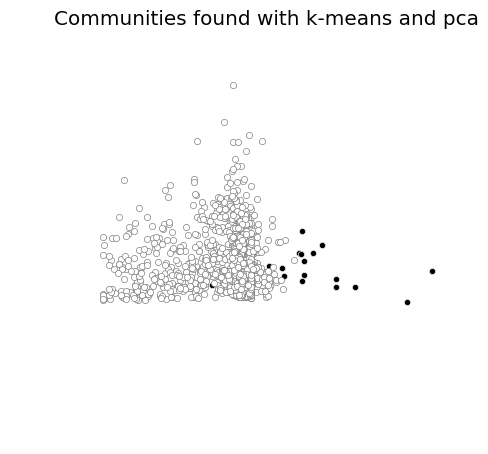

In [15]:
plot_communities(X, labels=labels_pca, method="k-means and pca")

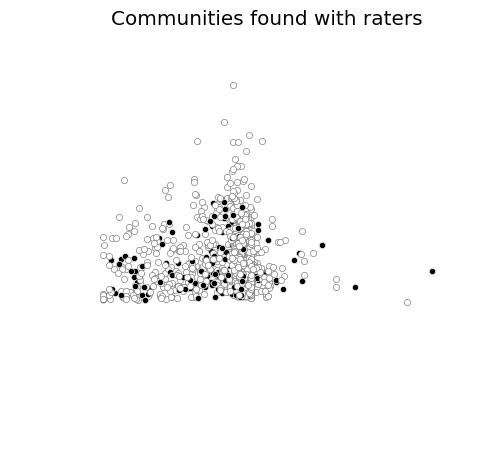

In [16]:
plot_communities(X, labels=rater, method="raters")

# Conclusion : 

> The unsupervised clustering gives two somehow well-defined communities (according to the silhouette score) but  these communities are actually split by some other factor (which is not the skin color but probably a latent one related to __nIAT__).

# Unsupervised classification fails to cluster according to skin color.